# Basic Training Scheme development notebook

## Importing section

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm

from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset, prepare_pure_test_dataset, \
    load_modified_ferris_wheel_dataset
from etnn.data.tree_structure import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from etnn.tools.loader import create_sampler
from etnn.tools.training import train_epoch, eval_epoch
from etnn.tools.training_tools import EpochControl, ConfigStore, AccuracyManager, seeding_all

In [2]:
import pandas as pd
import os

## Parameter definition

In [3]:
DATASET_PATH = "../datasets"

In [4]:
val_perc = 0.3
# todo: swap with artificially created testset (produced through permutations directly from trainset (hence directly learned)

In [5]:
MODEL_SAVING_NAME = "model.pt"

In [6]:
CONFIG_SAVING_NAME = "config.json"
ACCURACY_SAVING_NAME = "accuracies.csv"

In [7]:
config = ConfigStore(
    in_dim=15,
    hidden_dim=128,
    out_dim=1,
    k=2,
    dataset=0,
    ds_size=10_000,
    num_gondolas=10,
    num_part_pg=5,
    loss_name='mse',
    optimizer_name='adam',
    num_max_epochs=100, # old: 20
    learning_rate=0.001,
    batch_size=1024,
    early_stop_tol=5,
    use_equal_batcher=False,
    seed=420,
)

In [8]:
RESULTS_FOLDER = "../results"
CONFIG_INDEX_NAME = "config_index.csv"

In [9]:
# aquire saving path
if not os.path.exists(RESULTS_FOLDER):
    os.mkdir(RESULTS_FOLDER)

# create path where the config idx file should be located
config_idx_path = os.path.join(RESULTS_FOLDER, CONFIG_INDEX_NAME)

# define columns of index table
columns=['config_idx'] + list(vars(config).keys())

# if the config file exists - load it. else create a blank table
if os.path.isfile(config_idx_path):
    config_table = pd.read_csv(config_idx_path)
else:
    config_table = pd.DataFrame(columns=columns)

# create new entry
new_entry = pd.DataFrame(vars(config), index=[0])

# check if config in table already
merge = pd.merge(config_table, new_entry, on=columns[1:], how='inner')
if len(merge) == 0:
    if len(config_table) == 0:
        config_idx = 0
    else:
        config_idx = config_table['config_idx'].max() + 1

    # add this config to idx table
    new_entry['config_idx'] = config_idx
    pd.concat([config_table, new_entry]).to_csv(config_idx_path, index=False)
else:
    config_idx = merge.iloc[0]['config_idx']

In [10]:
config_idx

0

In [11]:
# if not present create the folder for this run
STORAGE_FOLDER = os.path.join(RESULTS_FOLDER, str(config_idx))
if not os.path.exists(STORAGE_FOLDER):
    os.mkdir(STORAGE_FOLDER)

## data preparation

In [12]:
#todo: add further with more permutated elements and with invalid elements
if config.dataset == 0:
    dataset, df_index = load_pure_ferris_wheel_dataset(
        num_gondolas=config.num_gondolas,
        num_part_pg=config.num_part_pg,
        num_to_generate=config.ds_size,
        dataset_path=DATASET_PATH,
        label_type="tree",
        final_label_factor=1/1000
    )
elif config.dataset == 1:
    dataset, df_index = load_modified_ferris_wheel_dataset(
        num_gondolas=config.num_gondolas,
        num_part_pg=config.num_part_pg,
        num_to_generate=int(config.ds_size * 0.8),
        num_valid_to_add=int(config.ds_size * 0.2),
        num_invalid_to_add=0,
        dataset_path=DATASET_PATH,
        try_pregen=True,
        label_type="default",
        final_label_factor=1/1000
    )
elif config.dataset == 2:
    dataset, df_index = load_modified_ferris_wheel_dataset(
        num_gondolas=config.num_gondolas,
        num_part_pg=config.num_part_pg,
        num_to_generate=int(config.ds_size * 0.6),
        num_valid_to_add=int(config.ds_size * 0.2),
        num_invalid_to_add=int(config.ds_size * 0.2),
        dataset_path=DATASET_PATH,
        try_pregen=True,
        label_type="default",
        final_label_factor=1/1000
    )
else:
    raise Exception("wrong selection")

In [13]:
len(dataset)

10000

In [14]:
generator = torch.Generator().manual_seed(config.seed)
train_ds, val_ds = random_split(
    dataset,
    [1-val_perc, val_perc],
    generator=generator
)

## Testset

In [15]:
test_ds, df_index_test = prepare_pure_test_dataset(
    df_index=df_index,
    train_indices=train_ds.indices,
    num_gondolas=config.num_gondolas,
    num_to_generate=len(val_ds),
    dataset_path=DATASET_PATH,
    seed=3*config.seed + 13
)

100%|██████████| 3000/3000 [00:00<00:00, 78352.80it/s]


## Loader

In [16]:
if config.use_equal_batcher:
    sampler = create_sampler(df_index=df_index, dataset=train_ds)
    train_loader = DataLoader(train_ds, batch_size=config.batch_size, sampler=sampler)
else:
    train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)

val_loader = DataLoader(val_ds, batch_size=4*config.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=4*config.batch_size, shuffle=False)

In [17]:
# todo: check which score should be used for early stopping and how to get it
# todo: add more tree mutated sequences that are in dataset
# todo: add some faulty sequences which disturb this and see how much this affects the training

## Build tree structure

In [18]:
tree_structure = TreeNode(
    node_type="C",
    children=[
        TreeNode("P", [TreeNode("E", config.num_part_pg)])
        for _ in range(config.num_gondolas)
    ]
)

## Define device

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
# device = 'cpu'

In [21]:
device

'cuda'

## Set up accuracy saving

In [22]:
accuracy_protocoller = AccuracyManager(
    storage_name=ACCURACY_SAVING_NAME,
    storage_path=STORAGE_FOLDER,
    is_classification=False
)

## Set seeds for reproducibility

In [23]:
seeding_all(config.seed)

## Define Model

In [24]:
model = LayerManagementFramework(
    in_dim=config.in_dim,
    tree=tree_structure,
    hidden_dim=config.hidden_dim,
    out_dim=config.out_dim,
    k=config.k
).to(device)

## Define Loss and Optimizers

In [25]:
if config.loss_name == 'mse':
    criterion = nn.MSELoss()
elif config.loss_name == 'mae':
    criterion = nn.L1Loss()
elif config.loss_name == 'smooth-l1':
    criterion = nn.SmoothL1Loss()
else:
    raise Exception("wrong selection")

In [26]:
if config.optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
elif config.optimizer_name == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
else:
    raise Exception("wrong selection")

## Training

In [27]:
epoch_control = EpochControl(
    model_save_name=MODEL_SAVING_NAME,
    config_save_name=CONFIG_SAVING_NAME,
    saving_folder_path=STORAGE_FOLDER,
    tolerance=config.early_stop_tol,
    is_accuracy_score=False
)

In [28]:
# train for N epochs
for epoch in tqdm(range(config.num_max_epochs)):
    train_mean_loss, train_true_y, train_pred_y = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    val_mean_loss, val_true_y, val_pred_y = eval_epoch(
        model,
        val_loader,
        device,
        criterion
    )

    # Not calculated for every step as the original purpose of test is to be tested for the best model/state
    # Note: this influences training and slows it down massively.
    #test_mean_loss, test_true_y, test_pred_y = eval_epoch(
    #    model,
    #    test_loader,
    #    device,
    #    criterion
    #)

    # use accuracy manager to calc accuracy metrics and save them
    accuracy_protocoller.calc_and_collect(
        config_id="etnn",
        epoch=epoch+1,
        train_y_true=train_true_y,
        train_y_pred=train_pred_y,
        train_loss=train_mean_loss,
        val_y_true=val_true_y,
        val_y_pred=val_pred_y,
        val_loss=val_mean_loss,
    #    test_y_true=test_true_y,
    #    test_y_pred=test_pred_y,
    #    test_loss=test_mean_loss,
    )

    # check if model is better and save it
    # todo: probably not required to write config over and over again
    if epoch_control.retain_best_and_stop(model, train_mean_loss, val_mean_loss, config):
        break

  1%|          | 1/100 [00:04<07:26,  4.51s/it]

++save++


  3%|▎         | 3/100 [00:12<06:30,  4.03s/it]

++save++


  4%|▍         | 4/100 [00:16<06:24,  4.01s/it]

++save++


  5%|▌         | 5/100 [00:20<06:22,  4.02s/it]

++save++


  6%|▌         | 6/100 [00:24<06:16,  4.01s/it]

++save++


 11%|█         | 11/100 [00:48<06:30,  4.38s/it]


## Repeat for baseline model

In [29]:
seeding_all(config.seed)

In [30]:
from etnn.nn.baseline import create_baseline_model, calc_params
model, _ =  create_baseline_model(
    n_params=calc_params(model),
    input_dim=config.in_dim * config.num_gondolas * config.num_part_pg,
    n_layer=3,
    output_dim=1
)
model = model.to(device)

In [31]:
if config.optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
elif config.optimizer_name == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
else:
    raise Exception("wrong selection")

In [32]:
epoch_control = EpochControl(
    model_save_name="a",
    config_save_name="b",
    saving_folder_path=STORAGE_FOLDER,
    tolerance=config.early_stop_tol,
    is_accuracy_score=False
)

In [33]:
# train for N epochs
for epoch in tqdm(range(config.num_max_epochs)):
    train_mean_loss, train_true_y, train_pred_y = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    val_mean_loss, val_true_y, val_pred_y = eval_epoch(
        model,
        val_loader,
        device,
        criterion
    )

    # use accuracy manager to calc accuracy metrics and save them
    accuracy_protocoller.calc_and_collect(
        config_id="baseline",
        epoch=epoch+1,
        train_y_true=train_true_y,
        train_y_pred=train_pred_y,
        train_loss=train_mean_loss,
        val_y_true=val_true_y,
        val_y_pred=val_pred_y,
        val_loss=val_mean_loss,
    )

    # check if model is better and save it
    if epoch_control.should_early_stop(train_mean_loss, val_mean_loss):
        break

100%|██████████| 100/100 [05:51<00:00,  3.52s/it]


## Plotting

In [34]:
df_measures = pd.read_csv(os.path.join(STORAGE_FOLDER, ACCURACY_SAVING_NAME))
df_measures

,config_id,epoch,train_loss,val_loss,test_loss,train_mse,train_msa,train_explained_variance,train_r2,val_mse,val_msa,val_explained_variance,val_r2,test_mse,test_msa,test_explained_variance,test_r2
0,etnn,1,46711.558594,1871.012695,0.0,47693.800781,144.468582,-154882.593750,-162701.342305,1871.012695,43.233154,-5.242908,-6124.061978,0.0,0.0,0.0,0.0
1,etnn,2,1620.428711,2560.722412,0.0,1563.773682,33.890720,-5093.238770,-5333.648068,2560.722412,50.578266,-7.385873,-8381.938131,0.0,0.0,0.0,0.0
2,etnn,3,1474.709229,1544.062988,0.0,1510.067749,30.793291,-4231.370605,-5150.435925,1544.063354,39.275101,-4.007419,-5053.739975,0.0,0.0,0.0,0.0
3,etnn,4,721.724548,1116.063232,0.0,737.131714,24.688011,-2343.561768,-2513.646929,1116.063110,33.388805,-3.094168,-3652.613133,0.0,0.0,0.0,0.0
4,etnn,5,321.649811,83.384933,0.0,328.326508,15.848224,-1031.588379,-1119.051093,83.384941,9.124454,0.576792,-271.974050,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,baseline,96,1.424884,1.595366,0.0,1.424984,0.903327,-3.860925,-3.861183,1.595366,0.943022,-4.176786,-4.222690,0.0,0.0,0.0,0.0
108,baseline,97,1.383362,1.535132,0.0,1.384645,0.890519,-3.720714,-3.723572,1.535132,0.912661,-4.024069,-4.025502,0.0,0.0,0.0,0.0
109,baseline,98,1.338809,1.497768,0.0,1.341688,0.874030,-3.576787,-3.577027,1.497768,0.895632,-3.882572,-3.903186,0.0,0.0,0.0,0.0
110,baseline,99,1.301358,1.452135,0.0,1.302252,0.860224,-3.440499,-3.442496,1.452135,0.887502,-3.749748,-3.753800,0.0,0.0,0.0,0.0


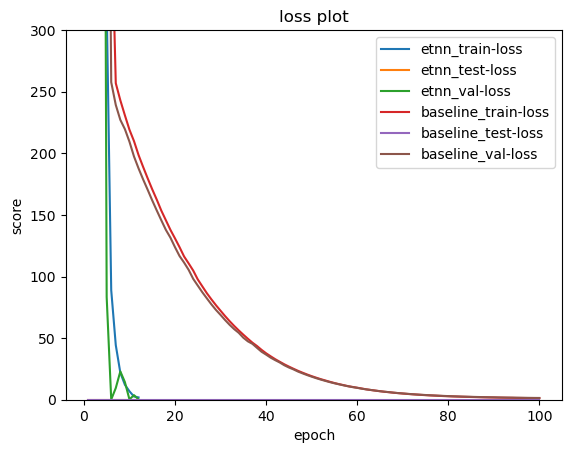

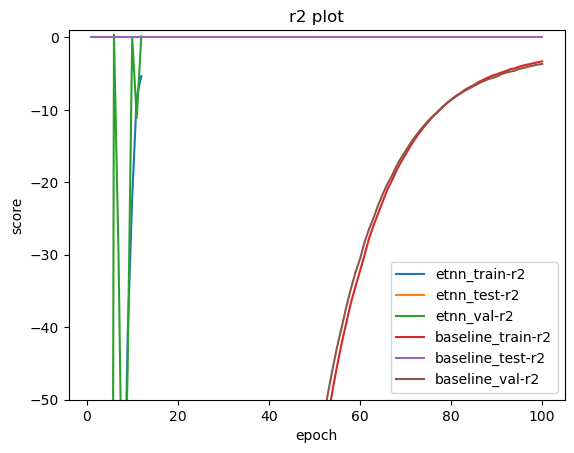

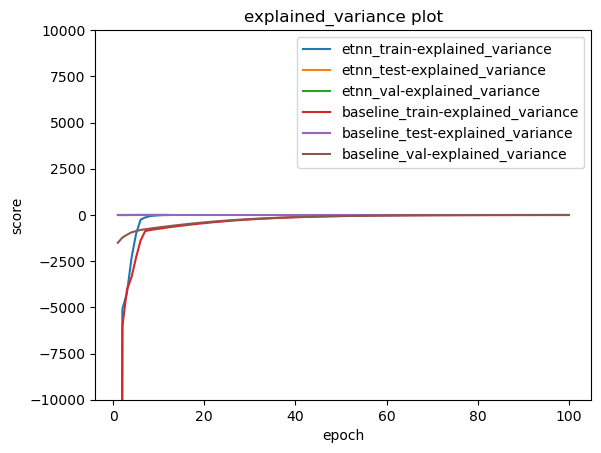

In [48]:
for what in ['loss', 'r2', 'explained_variance']:
    plt.figure()
    for config_id in df_measures.config_id.unique():
        # make subdataset for config id
        sub_df = df_measures[df_measures.config_id == config_id]

        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == 'r2':
        # plt.ylim(-1,1)
        plt.ylim(-50,1)
    elif what == 'loss':
        plt.ylim(0, 300)
    elif what == 'explained_variance':
        plt.ylim(-10_000, 10_000)
    plt.legend()
    plt.show()

## Loading etnn model

In [36]:
model = LayerManagementFramework(
    in_dim=config.in_dim,
    tree=tree_structure,
    hidden_dim=config.hidden_dim,
    out_dim=config.out_dim,
    k=config.k
).to(device)

In [37]:
model.load_state_dict(torch.load(os.path.join(STORAGE_FOLDER, MODEL_SAVING_NAME)))

<All keys matched successfully>

In [38]:
loss, y_true, y_pred = eval_epoch(model, test_loader, device, criterion)

In [39]:
loss

tensor(0.1871)

In [40]:
import sklearn

print(sklearn.metrics.r2_score(y_true=y_true, y_pred=y_pred))

0.35378645852881185
